Perceptron Code: https://github.com/jacksonbhanson7/jacksonbhanson7.github.io/blob/main/posts/Implementing%20the%20Perceptron%20Algorithm/perceptron.py

In [92]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

# Blog Post 4 - Implementing the Perceptron Algorithm

# Abstract

In this blog post, we will explore the perceptron algorithm and its minibatch variant through a series of experiments on different datasets. We begin by implementing the core perceptron update rule, including support for minibatch update, and validating our implementation on both linearly separable and non-separable data. Towards the end, we will tweak with batch size (k) and learning rate (alpha), and demonstrate how minibatch perceptron is different than the origioal perceptron alog. Visualizations of loss, score trajectories, and desision boundaries are included throughout the post.

# Part B

First, let's generate and vizualize some linearly separable data in 2d. We can use the `perceptron_data` function to do so.

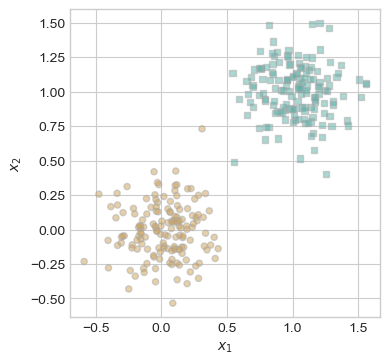

In [93]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    
    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

Clearly this data is linearly separable, so Perceptron is guarenteed to find a separation line. 

Now, let's vizualize the loss over the course of the algorithm. Because we know this data is linearly separable, we can run this dangerous while loop because we know it will converge.

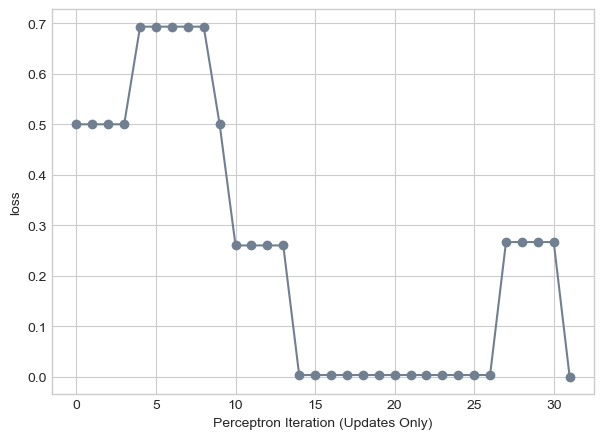

In [94]:
from perceptron import Perceptron, PerceptronOptimizer
torch.manual_seed(1234567)
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

We can use Phil's `draw_line` function to see some desision boundaries and how they progress as iterations increase. 

In [95]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

Now let's see how the desision boundaries evolve using the Phil's code from lecture notes. 

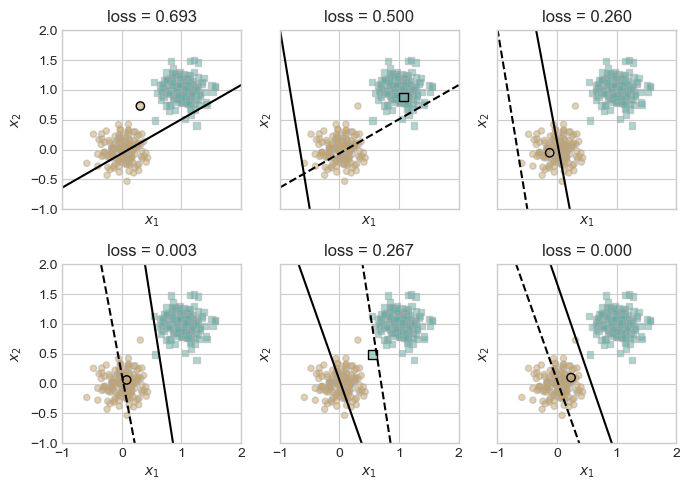

In [96]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

Now, I've created a new data-generating function that will flip the class of a fraction of points. This will make the data messier so that we can experiment with some non linarly separable data. 

In [97]:
def perceptron_data_with_label_noise(n_points=300, noise=0.2, p_dims=2, flip_frac=0.1):
    y = (torch.arange(n_points) >= int(n_points / 2)).int()
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    n_flip = int(flip_frac * n_points)
    flip_indices = torch.randperm(n_points)[:n_flip]
    y[flip_indices] = 1 - y[flip_indices]  

    return X, y



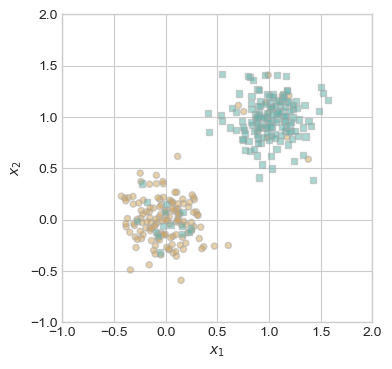

In [98]:
X, y = perceptron_data_with_label_noise(300, noise=0.2, p_dims = 2, flip_frac=0.1)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)


Notice how there is overlap between the blue and orange points in this data.

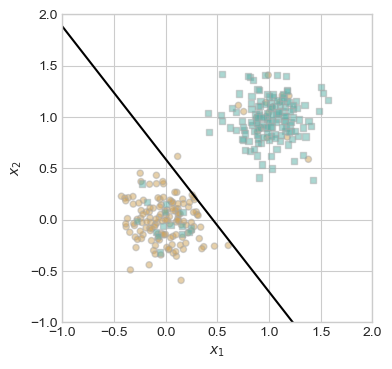

In [99]:
from perceptron import Perceptron, PerceptronOptimizer

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []
score_vec = []

n = X.size()[0]

iterations = 0

while loss > 0 and iterations < 1000: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    avg_score = p.score(X).mean()
    score_vec.append(avg_score)

    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)
    iterations += 1


fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")


This is the desision boundary after 1000 iterations. Because this data is not lienarly separable, loss never got to 0.

Text(0.5, 1.0, 'Perceptron Score Over Time')

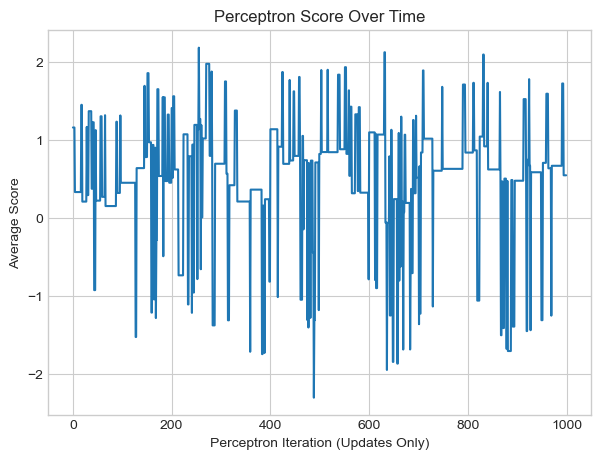

In [100]:
plt.plot(score_vec)
plt.xlabel("Perceptron Iteration (Updates Only)")
plt.ylabel("Average Score")
plt.title("Perceptron Score Over Time")


This plot shows the evolution of the average score over time while training the Perceptron on non-linearly separable 2D data. The score fluctuates heavily across iterations, indicating that the algorithm struggles to consistently separate the data — which is expected when perfect separation isn't possible. The lack of convergence or stabilization in the score confirms the non-linearly separable nature of the dataset.

Now, let's run the perceptron algorithm on data that isn't 2d. I am setting `p_dims` to 5 instead of 2 in this experiment. 

In [103]:
# Generate data with 5 features (plus bias)
X, y = perceptron_data(n_points=300, noise=0.3, p_dims=5)  # no noise so it’s linearly separable

# Perceptron setup
p = Perceptron()
opt = PerceptronOptimizer(p)

loss = 1.0
loss_vec = []
score_vec = []

n = X.size()[0]
iterations = 0

# Training loop
while loss > 0 and iterations < 1000:
    loss = p.loss(X, y)
    loss_vec.append(loss)

    avg_score = p.score(X).mean()
    score_vec.append(avg_score)
    
    # Pick a random example
    i = torch.randint(n, size=(1,))
    x_i = X[i, :]
    y_i = y[i]

    

    # Perform perceptron update
    opt.step(x_i, y_i)
    iterations += 1


Text(0.5, 1.0, 'Perceptron Score Over Time')

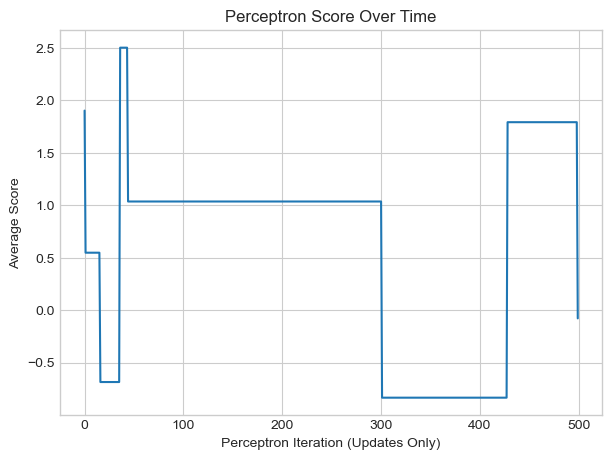

In [104]:
plt.plot(score_vec)
plt.xlabel("Perceptron Iteration (Updates Only)")
plt.ylabel("Average Score")
plt.title("Perceptron Score Over Time")

The score plot shows that the average score becomes more stable and consistently positive over the training period. This suggests that the perceptron is learning a reliable decision boundary. Given that the data was generated without label noise and the score stabilizes quickly, I believe the dataset is linearly separable.

# Part C

This function run_minibatch_experiment encapsulates the training loop for the minibatch Perceptron algorithm. It takes in the data, batch size k, learning rate alpha, and maximum number of iterations. In each iteration, it selects a random minibatch of k examples, performs a Perceptron update, and tracks the loss. You're using this function to compare how different batch sizes affect convergence and performance, including full-batch training on noisy (non-linearly separable) data.

In [105]:
# Function to run minibatch perceptron
def run_minibatch_experiment(X, y, k, alpha=1.0, max_iter=1000):
    p = Perceptron()
    opt = PerceptronOptimizer(p, alpha=alpha)
    loss_vec = []

    n = X.shape[0]
    iterations = 0
    loss = 1.0

    while loss > 0 and iterations < max_iter:
        loss = p.loss(X, y)
        loss_vec.append(loss.item())

        # Get random minibatch
        ix = torch.randperm(n)[:k]
        x_i = X[ix, :]
        y_i = y[ix]

        opt.step(x_i, y_i)
        iterations += 1

    return loss_vec



In [121]:
# Experiment 1: k = 1 (standard perceptron)
X1, y1 = perceptron_data()
loss_k1 = run_minibatch_experiment(X1, y1, k=1)

# Experiment 2: k = 10
X2, y2 = perceptron_data()
loss_k10 = run_minibatch_experiment(X2, y2, k=10)

# Experiment 3: k = n with non-linearly separable data
X3, y3 = perceptron_data_with_label_noise(flip_frac=.1)
loss_kn = run_minibatch_experiment(X3, y3, k=X3.shape[0], alpha=0.0001, max_iter=20000)  # note: smaller alpha!


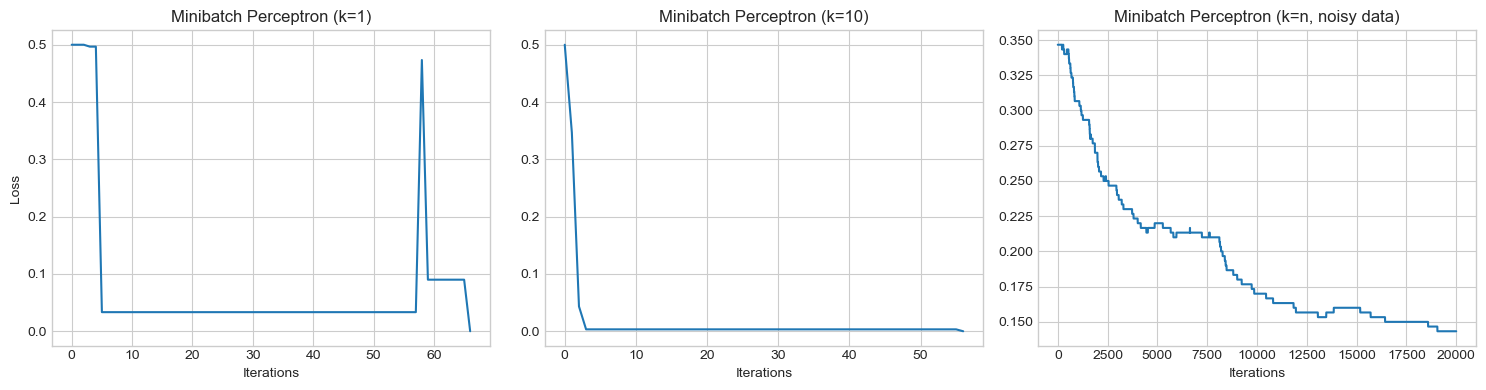

In [122]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(loss_k1)
axs[0].set_title("Minibatch Perceptron (k=1)")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Loss")

axs[1].plot(loss_k10)
axs[1].set_title("Minibatch Perceptron (k=10)")
axs[1].set_xlabel("Iterations")

axs[2].plot(loss_kn)
axs[2].set_title("Minibatch Perceptron (k=n, noisy data)")
axs[2].set_xlabel("Iterations")

plt.tight_layout()
plt.show()


These three graphs show how the minibatch perceptron algorithm performs with different batch sizes under various conditions.When k = 1 The perceptron converges quickly and the loss drops to zero within a few hundred iterations. This looks similar to the perceptron I performed earlier without the mini-batch update. When k = 10, the loss converges even faster and more smoothly than the standard perceptron. Maybe the larger batch size provides more stable updates, helping the model find a desision boundary faster in the linearly separable case. When k = n and the data is not LS, (labels are switched), the perceptron still converges after many iterations, but only when using a very small learning rate (alpha = 0.0001). The slow convergence reflects the difficulty in minimizing classification error on noisy data, but the stability of full batch updates makes progress possible.

# Part D

grad() walkthrough: This function implements the update for the minibatch perceptron algorithm. It begins by converting binary class labels y into the values {-1, 1} using y_hat = 2 * y - 1. The model computes a score s for each data point using the current weights w, and checks which points are misclassified by evaluating whether s * y_hat < 0. For the misclassified points, it computes their contribution to the weight update as - y_hat * x, while assigning no contribution from correctly classified points. These individual updates are then averaged across the minibatch using .mean(dim=0), aligning with the update rule described in the course: averaging the adjustments from misclassified examples and scaling by the learning rate α. This function mirrors the logic of Equation (1) from the instructions. 

Runtime: The runtime complexity of a single iteration of the standard perceptron algorithm is O(p), where p is the number of features, because each update involves a dot product between the weight vector and a single data point. In this case, the time complexity does not depend on n, the total number of data points, since the perceptron updates using only one random point per iteration. However, in the minibatch perceptron, each iteration uses k points, so the complexity becomes O(kp). When k = n, meaning a full batch is used, the complexity becomes O(np). Thus, while the standard perceptron scales only with the number of features, the minibatch version introduces a dependence on the batch size. 

# Conclusion

In conclusion, this blog post explored the perceptron algorithm and its ability to find linear decision boundaries through iterative updates based on classification errors. We implemented the core update rule and visualized how the algorithm learns over time across different settings and datasets. In the latter part of the project, we extended the perceptron to support minibatch updates, which allowed us to average updates across multiple examples, improving stability and enabling convergence even in the presence of noise. These experiments highlighted both the strengths and limitations of the perceptron and provided a foundation for understanding more advanced linear classifiers.